In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [41]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from utils_upper_bound import *

### Test (temporary, to be removed)

In [4]:
# Matrix shape and rank
n1, n2 = 100, 100
k = 3
r = 3
prop_obs = 0.2
random_state = 1
allow_inf = False
alpha = 0.1

In [5]:
max_test_queries = 1
bias_scale = 2
sampler = QuerySampling(n1,n2)
bias = SamplingBias(n1,n2)

# Split observation mask uniformly
mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Sample test queries with weights
w = bias.inc_weights(scale = bias_scale)
n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

In [6]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

In [7]:
mask_test = np.zeros_like(mask_miss)
mask_test[idxs_test]=1


In [8]:
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 2000, training size: 1049,  calib queries: 317, test queries: 1


In [9]:
# Train matrix completion model
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0008
Iteration: 2; Mean diff: 0.0001
Iteration: 3; Mean diff: 0.0001
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Iteration: 8; Mean diff: 0.0000
Iteration: 9; Mean diff: 0.0000
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Stopping criteria met, training terminated.


In [10]:
ci_method = SimulCI_upper_bound(M, Mhat, mask_obs, idxs_calib, k)
max_weight = ci_method.get_max_weight(idxs_test, w_test= w)

Computing maximum weights for 1 test queries...
Done computing maximum weights!


In [11]:
print(max_weight)

[0.02064326]


In [12]:
np.mean(max_weight)

0.0206432556894687

In [13]:
1/(n_calib_queries+1)

0.0031446540880503146

# Upper bound analysis

In [76]:
# Matrix shape, rank, and other parameters
n1, n2 = 100, 100
k = 2
r = 3
prop_obs = 0.2

allow_inf = False
alpha = 0.1

max_test_queries = 1  # Set to compute max weight for one test query per loop
bias_scale = 2
iterations = 10  # Number of iterations to repeat the random procedure
max_calib_queries = 100


# Generate a random true matrix once, as it's not used in the computation of max_weight
RFM = RandomFactorizationModel(n1, n2, r)
U, V, M = RFM.sample_noiseless(random_state)
Mhat, Uhat, Vhat = M, U, V

max_weights = []  # Store max weights here

for _ in range(iterations):
    random_state = _
    sampler = QuerySampling(n1, n2)
    bias = SamplingBias(n1, n2)


    # Sample a single test query with weights
    w = bias.inc_weights(scale=bias_scale)
    mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)
    n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
    idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)
    
    mask_test = np.zeros_like(mask_miss)
    mask_test[idxs_test]=1
    
    
    
    # 50% of observation is calibration or max_calib_queries
    n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)


    mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                            calib_size=n_calib_queries, random_state=random_state)
    
    print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

    # Initialize SimulCI_upper_bound class and compute max weight for the single test query
    ci_method = SimulCI_upper_bound(M, Mhat, mask_obs, idxs_calib, k)
    max_weight = ci_method.get_max_weight(idxs_test, w_test=w)

    max_weights.append(max_weight[0])

# Calculate the average of the maximum weights
average_max_weight = np.mean(max_weights)

print(f"Average Maximum Weight: {average_max_weight}")

Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Average Maximum Weight: 0.029529026885091313


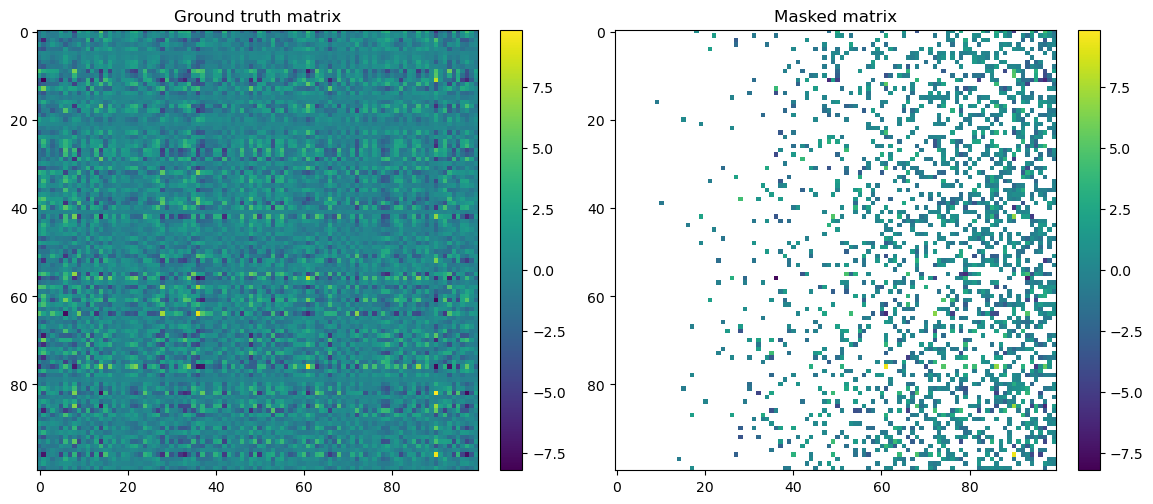

Missing entries are masked in white.


In [77]:
fig = plot_before_after_mask(np.transpose(M), np.transpose(mask_obs), bad_color="white")
print("Missing entries are masked in white.")

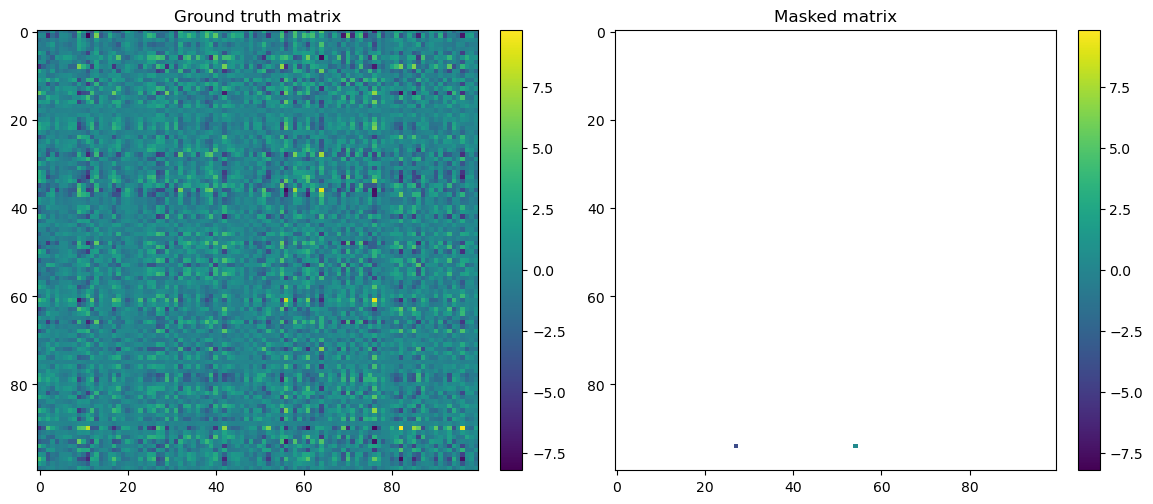

Test entries are masked in white, unique test entries: 2


In [78]:
plot_before_after_mask(M, mask_test, bad_color="white")
print("Test entries are masked in white, unique test entries: {}".format(np.sum(mask_test)))

### For different number of calibration queries

In [130]:
n_calib_queries_lists = [50, 100, 150, 200, 250, 300]
iterations = 10  # Number of iterations to repeat the random procedure
experiment_results = pd.DataFrame(columns=['matrix_size', 'n_calib_queries', 'avg_max_weight'])

for n_calib_queries_list in n_calib_queries_lists:
    n1, n2 = 100, 100
    k = 2
    r = 3
    prop_obs = 0.2

    allow_inf = False
    alpha = 0.1

    max_test_queries = 1  # Set to compute max weight for one test query per loop
    bias_scale = 2

    max_calib_queries = n_calib_queries_list


    # Generate a random true matrix once, as it's not used in the computation of max_weight
    RFM = RandomFactorizationModel(n1, n2, r)
    U, V, M = RFM.sample_noiseless(random_state)
    Mhat, Uhat, Vhat = M, U, V

    max_weights = []  # Store max weights here

    for _ in range(iterations):
        random_state = _
        sampler = QuerySampling_upper_bound(n1, n2)
        bias = SamplingBias(n1, n2)


        # Sample a single test query with weights
        w = bias.inc_weights(scale=bias_scale)
        mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)
        n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
        idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

        mask_test = np.zeros_like(mask_miss)
        mask_test[idxs_test]=1



        # 50% of observation is calibration or max_calib_queries
        n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)


        mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                                calib_size=n_calib_queries, random_state=random_state)

        print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
          .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

        # Initialize SimulCI_upper_bound class and compute max weight for the single test query
        ci_method = SimulCI_upper_bound(M, Mhat, mask_obs, idxs_calib, k)
        max_weight = ci_method.get_max_weight(idxs_test, w_test=w)

        max_weights.append(max_weight[0])

    # Calculate the average of the maximum weights
    average_max_weight = np.mean(max_weights)
    
    temp_df = pd.DataFrame({
        'matrix_size': [n1],
        'n_calib_queries': [int(np.sum(mask_calib)//k)],
        'avg_max_weight': [average_max_weight]
    })
    experiment_results = pd.concat([experiment_results, temp_df], ignore_index=True)


Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1900,  calib queries: 50, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, tr

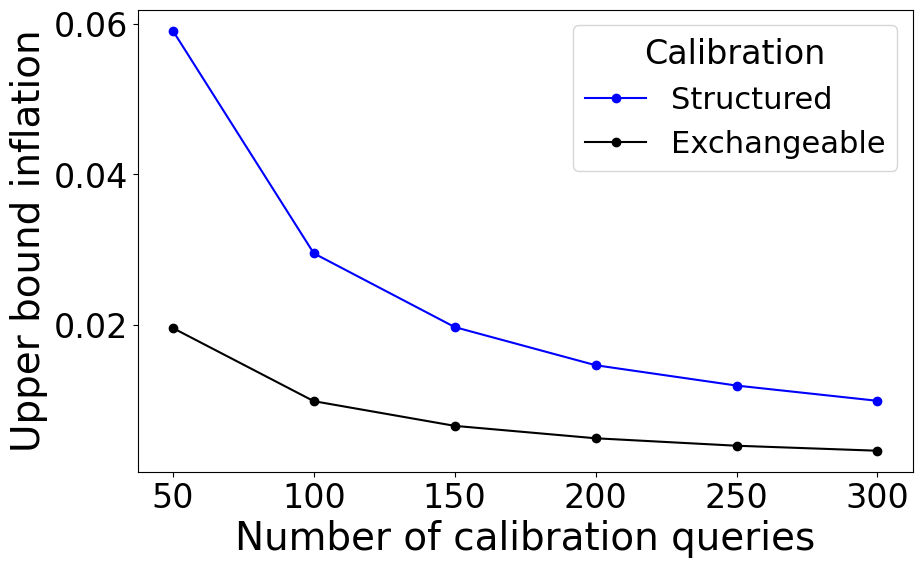

In [150]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(experiment_results['n_calib_queries'], experiment_results['avg_max_weight'],
         marker='o', linestyle='-', color='blue', label='Structured')

# upper bound for exchangeable case
plt.plot(experiment_results['n_calib_queries'], 1 / (experiment_results['n_calib_queries'] + 1),
         marker='o', linestyle='-', color='black', label='Exchangeable')

plt.xlabel('Number of calibration queries', fontsize=28)
plt.ylabel('Upper bound inflation', fontsize=28)
# plt.title('Comparison of Structured vs Exchangeable Upper Bounds')

# Adding the legend to differentiate between structured and exchangeable
plt.legend(title='Calibration')
plt.savefig('weighted_upper_bound_calibration_size.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [132]:
experiment_results

,matrix_size,n_calib_queries,avg_max_weight
0,100,50,0.059081
1,100,100,0.029529
2,100,150,0.019737
3,100,200,0.014674
4,100,250,0.011972
5,100,300,0.009949


<Figure size 640x480 with 0 Axes>

### For different matrix size with same proportion of calibrations

In [126]:
# Define different matrix sizes to experiment with
matrix_sizes = [100, 120, 140, 160, 180, 200]
prop_calib = 0.2  # Proportion of observations to use for calibration
iterations = 10
experiment_results_matrix_size_squared_bias = pd.DataFrame(columns=['matrix_size', 'n_calib_queries', 'avg_max_weight'])


for _ in matrix_sizes:
    n1 = _
    n2 = _
    k = 2
    r = 3
    prop_obs = 0.2

    allow_inf = False
    alpha = 0.1

    max_test_queries = 1  # Set to compute max weight for one test query per loop
    bias_scale = 2
    



    # Generate a random true matrix once, as it's not used in the computation of max_weight
    RFM = RandomFactorizationModel(n1, n2, r)
    U, V, M = RFM.sample_noiseless(random_state)
    Mhat, Uhat, Vhat = M, U, V

    max_weights = []  # Store max weights here

    for _ in range(iterations):
        random_state = _
        sampler = QuerySampling(n1, n2)
        bias = SamplingBias(n1, n2)


        # Sample a single test query with weights
        w = bias.inc_weights(scale=bias_scale)
        mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)
        n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
        idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

        mask_test = np.zeros_like(mask_miss)
        mask_test[idxs_test]=1
        
        total_obs = int(np.sum(mask_obs))
        max_calib_queries = int(total_obs * prop_calib // k)



        # 50% of observation is calibration or max_calib_queries
        n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)


        mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                                calib_size=n_calib_queries, random_state=random_state)

        print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
          .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

        # Initialize SimulCI_upper_bound class and compute max weight for the single test query
        ci_method = SimulCI_upper_bound(M, Mhat, mask_obs, idxs_calib, k)
        max_weight = ci_method.get_max_weight(idxs_test, w_test=w)

        max_weights.append(max_weight[0])

    # Calculate the average of the maximum weights
    average_max_weight = np.mean(max_weights)
    
    temp_df = pd.DataFrame({
        'matrix_size': [n1],
        'n_calib_queries': [int(np.sum(mask_calib)//k)],
        'avg_max_weight': [average_max_weight]
    })
    experiment_results_matrix_size_squared_bias = pd.concat([experiment_results_matrix_size_squared_bias, temp_df], ignore_index=True)


Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2000, training size: 1600,  calib queries: 200, test queries: 1
Observation size: 2880, training size: 2304,  calib queries: 288, test queries: 1
Observation size: 2880, training size: 2304,  calib queries: 288, test queries: 1
Observation size

In [127]:
experiment_results_matrix_size_squared_bias

,matrix_size,n_calib_queries,avg_max_weight
0,100,200,0.014674
1,120,288,0.010549
2,140,392,0.007607
3,160,512,0.005644
4,180,648,0.004535
5,200,800,0.003808


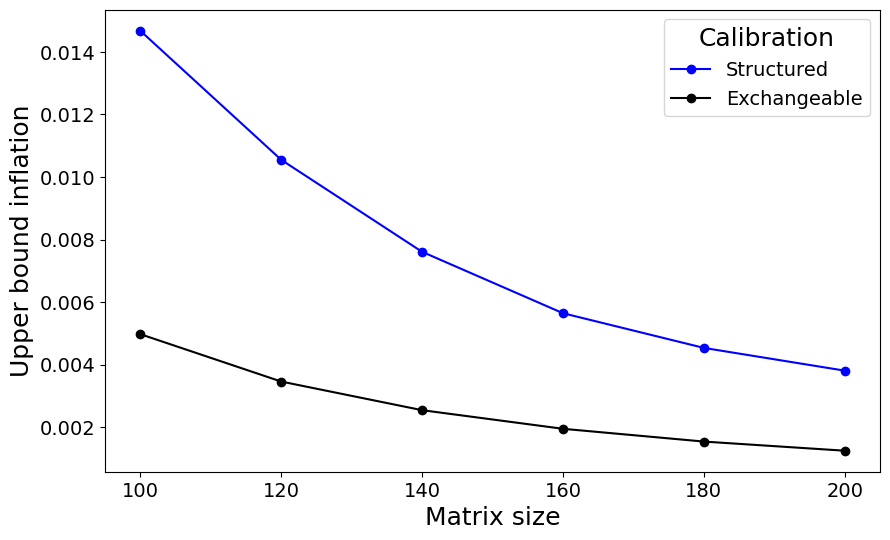

In [136]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(experiment_results_matrix_size_squared_bias['matrix_size'], experiment_results_matrix_size_squared_bias['avg_max_weight'],
         marker='o', linestyle='-', color='blue', label='Structured')

# upper bound for exchangeable case
plt.plot(experiment_results_matrix_size_squared_bias['matrix_size'], 1 / (experiment_results_matrix_size_squared_bias['n_calib_queries'] + 1),
         marker='o', linestyle='-', color='black', label='Exchangeable')

plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Upper bound inflation', fontsize=18)
# plt.title('Comparison of Structured vs Exchangeable Upper Bounds')

# Adding the legend to differentiate between structured and exchangeable
plt.legend(title='Calibration', fontsize=14, title_fontsize = 18)
plt.savefig('weighted_upper_bound_matrix_size_squared_bias.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [129]:
plt.savefig('weighted_upper_bound_matrix_size_squared_bias.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

### Issue for larger matrices?

In [103]:
import pdb

# Define different matrix sizes to experiment with
matrix_sizes = [100, 150, 200, 250, 300]
prop_calib = 0.1  # Proportion of observations to use for calibration
iterations = 10
experiment_results_matrix_size = pd.DataFrame(columns=['matrix_size', 'n_calib_queries', 'avg_max_weight'])


for _ in matrix_sizes:
    n1 = _
    n2 = _
    k = 2
    r = 3
    prop_obs = 0.2

    allow_inf = False
    alpha = 0.1

    max_test_queries = 1  # Set to compute max weight for one test query per loop
    bias_scale = 1
    



    # Generate a random true matrix once, as it's not used in the computation of max_weight
    RFM = RandomFactorizationModel(n1, n2, r)
    U, V, M = RFM.sample_noiseless(random_state)
    Mhat, Uhat, Vhat = M, U, V

    max_weights = []  # Store max weights here

    for _ in range(iterations):
        random_state = _
        sampler = QuerySampling(n1, n2)
        bias = SamplingBias(n1, n2)


        # Sample a single test query with weights
        w = bias.inc_weights(scale=bias_scale)
        mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)
        n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
        idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

        mask_test = np.zeros_like(mask_miss)
        mask_test[idxs_test]=1
        
        total_obs = int(np.sum(mask_obs))
        max_calib_queries = int(total_obs * prop_calib // k)



        # 50% of observation is calibration or max_calib_queries
        n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)


        mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                                calib_size=n_calib_queries, random_state=random_state)

        print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
          .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

        # Initialize SimulCI_upper_bound class and compute max weight for the single test query
        ci_method = SimulCI_upper_bound(M, Mhat, mask_obs, idxs_calib, k)
        max_weight = ci_method.get_max_weight(idxs_test, w_test=w)

        max_weights.append(max_weight[0])

    # Calculate the average of the maximum weights
    average_max_weight = np.mean(max_weights)
    
    temp_df = pd.DataFrame({
        'matrix_size': [n1],
        'n_calib_queries': [int(np.sum(mask_calib)//k)],
        'avg_max_weight': [average_max_weight]
    })
    experiment_results_matrix_size = pd.concat([experiment_results_matrix_size, temp_df], ignore_index=True)


Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 2000, training size: 1800,  calib queries: 100, test queries: 1
Observation size: 4500, training size: 4050,  calib queries: 225, test queries: 1
Observation size: 4500, training size: 4050,  calib queries: 225, test queries: 1
Observation size

In [146]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set default font sizes
mpl.rcParams['axes.labelsize'] = 28  # For x and y labels
mpl.rcParams['xtick.labelsize'] = 24  # For x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 24  # For y-axis tick labels
mpl.rcParams['legend.title_fontsize'] = 24  # For legend title
mpl.rcParams['legend.fontsize'] = 22  # For legend text
mpl.rcParams['axes.titlesize'] = 16  # For plot title

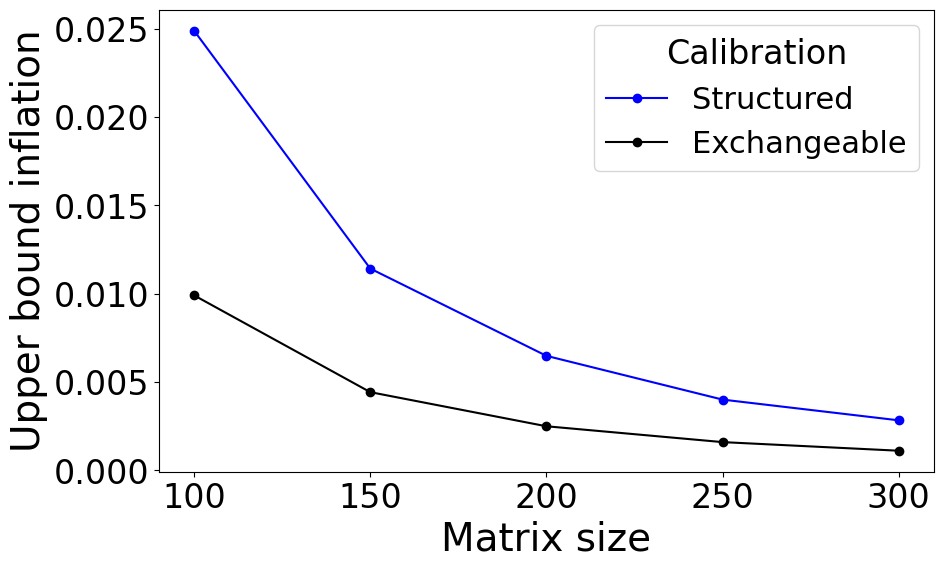

In [151]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(experiment_results_matrix_size['matrix_size'], experiment_results_matrix_size['avg_max_weight'],
         marker='o', linestyle='-', color='blue', label='Structured')

# upper bound for exchangeable case
plt.plot(experiment_results_matrix_size['matrix_size'], 1 / (experiment_results_matrix_size['n_calib_queries'] + 1),
         marker='o', linestyle='-', color='black', label='Exchangeable')

plt.xlabel('Matrix size', fontsize=28)
plt.ylabel('Upper bound inflation', fontsize=28)
# plt.title('Comparison of Structured vs Exchangeable Upper Bounds')

# Adding the legend to differentiate between structured and exchangeable
plt.legend(title='Calibration')

plt.savefig('weighted_upper_bound_matrix_size.pdf', format='pdf', bbox_inches='tight')
plt.show()